In [67]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from scipy import integrate
import glob
import seaborn as sns
# %matplotlib notebook
%matplotlib inline
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from fitter import Fitter, get_common_distributions, get_distributions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Estimation of CAFOs sizes distribution for the states of:

- Ohio
- Pennsylvania
- Indiana
- Michigan
- Wisconsin

Import data files

# We filter the CAFOs, considering a range between 300 and 10,000 animal units

In [84]:
CAFOs_Ohio = pd.read_csv('USCafosData/Ohio_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Michigan = pd.read_csv('USCafosData/Michigan_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Wisconsin = pd.read_csv('USCafosData/Wisconsin_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Pennsylvania = pd.read_csv('USCafosData/Pennsylvania_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Indiana = pd.read_csv('USCafosData/Indiana_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)

CAFOs_Dict ={'Ohio':CAFOs_Ohio[(CAFOs_Ohio['Animal Units']> 300) & (CAFOs_Ohio['Animal Units']< 10000)]['Animal Units'],
             'Michigan':CAFOs_Michigan[(CAFOs_Michigan['Animal Units']> 300) & (CAFOs_Michigan['Animal Units']< 10000)]['Animal Units'],
             'Wisconsin':CAFOs_Wisconsin[(CAFOs_Wisconsin['Animal Units']> 300) & (CAFOs_Wisconsin['Animal Units']< 10000)]['Animal Units'],
             'Pennsylvania':CAFOs_Pennsylvania[(CAFOs_Pennsylvania['Animal Units']> 300) & (CAFOs_Pennsylvania['Animal Units']< 10000)]['Animal Units'],
             'Indiana':CAFOs_Indiana[(CAFOs_Indiana['Animal Units']> 300) & (CAFOs_Indiana['Animal Units']< 10000)]['Animal Units']}

CAFOs_Merged = pd.DataFrame(data = CAFOs_Dict)
CAFOs_Merged.describe().to_csv('CAFOsStatisticsSummary'+'.csv')
CAFOs_Merged

,Ohio,Michigan,Wisconsin,Pennsylvania,Indiana
0,4000.0,1500.0,1000.0,612.04,2000.0
1,2070.0,7601.0,2013.0,1509.75,1650.0
2,1085.0,2000.0,1214.0,1737.42,750.0
3,820.0,4500.0,1604.0,384.34,NaN
4,1200.0,4500.0,860.0,1070.86,575.0
5,3600.0,2900.0,2792.0,720.52,500.0
6,1072.0,950.0,1500.0,915.30,1200.0
7,3020.0,2375.0,1105.0,660.18,560.0
8,9800.0,500.0,2521.0,NaN,600.0
9,1838.0,1990.0,2531.0,619.30,557.0


In [85]:
CAFOs_Merged.describe()

,Ohio,Michigan,Wisconsin,Pennsylvania,Indiana
count,53.000000,144.000000,276.000000,130.000000,115.000000
mean,2415.245283,2461.527778,2393.431159,1398.357923,1529.521739
std,1588.246879,1333.813099,1457.032638,1076.216680,1541.598523
min,820.000000,420.000000,396.000000,328.400000,310.000000
25%,1500.000000,1347.500000,1499.000000,670.910000,500.000000
50%,2000.000000,2225.000000,1941.500000,1215.245000,760.000000
75%,2800.000000,3420.000000,2812.250000,1700.362500,1959.500000
max,9800.000000,7601.000000,9979.000000,7533.190000,7040.000000


In [86]:
def NumberOfBins(data_list): #computing the optimal number of bins using the Freedman-Diaconis rule
    # Computing IQR
    Q1 = data_list.quantile(0.25)
    Q3 = data_list.quantile(0.75)
    IQR = Q3 - Q1

    bins_width = 2*IQR/(data_list.count()**(1/3)) #Freedman-Diaconis rule

    bins_number = int(round((data_list.max()-data_list.min())/bins_width,0))
    return bins_number

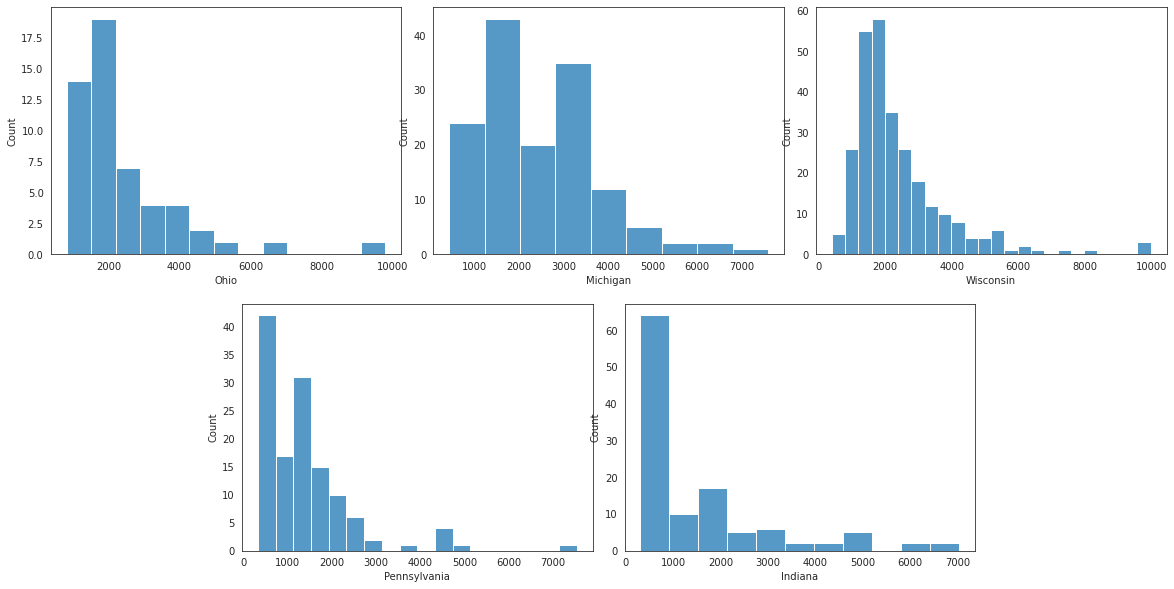

In [88]:
sns.set_style('white')

# fig, ax =plt.subplots(2,3,figsize=(20,10))

# ax_rows = np.arange(0,len(ax)) #This is because it is 2 dimensional array
# ax_columns = np.arange(0,len(ax[0])) #This is because it is 2 dimensional array

# ax_matrix = []#This is because it is 2 dimensional array
# for i in ax_rows:
#     for ii in ax_columns:
#         ax_element = [i,ii]
#         ax_matrix.append(ax_element) 
        
# sns.histplot(CAFOs_Merged[state].dropna(), ax=ax[ax_number[0]][ax_number[1]])


fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 6)

count = 0
for state in CAFOs_Merged.columns:
    if count < 3: #This is for centering the last row of plots
        ax = plt.subplot(gs[0, 2 * count:2 * count + 2])
    else:
        ax = plt.subplot(gs[1, 2 * count - 5:2 * count + 2 - 5])
              
    sns.histplot(CAFOs_Merged[state].dropna(), ax=ax, bins=NumberOfBins(CAFOs_Merged[state].dropna()) )
    count = count+1

# fig.delaxes(ax[ax_matrix[-1][0],ax_matrix[-1][1]])

In [ ]:
# fitting_values = CAFOs_Ohio['Animal Units'].values

# fit_variable = Fitter(fitting_values,
#                distributions=[
#                               'gamma',
#                               'lognorm',
#                               "beta",
#                               "gennorm",
#                               "t",
#                               "norm",
#                                "lognorm",
#                                "dweibull"]
#                                      )
# fit_variable.fit()
# fit_variable.summary()

Fits_CAFOs_Summary = dict()
for state in CAFOs_Merged:
    fitting_values = CAFOs_Merged[state].dropna().values

    fit_variable = Fitter(fitting_values,
                   distributions=[
                                  'gamma',
                                  'lognorm',
                                  "beta",
                                  "gennorm",
                                  "t",
                                  "norm",
                                   "lognorm",
                                   "dweibull"]
                                         )
    fit_variable.fit()
    print(state)
    fit_variable.summary()
    Fits_CAFOs_Summary[state] = fit_variable.summary()
    fit_variable.summary().plot()

In [ ]:
Fits_CAFOs_Summary

In [ ]:
Fits_CAFOs_Summary = dict()
for state in CAFOs_Merged:
    fitting_values = CAFOs_Merged[state].dropna().values

    fit_variable = Fitter(fitting_values,
                   distributions=get_common_distributions()
                                         )
    fit_variable.fit()
    print(state)
    fit_variable.summary()
    Fits_CAFOs_Summary[state] = fit_variable.summary()
    fit_variable.summary().plot()

# After a visual analysis of the distributions we select the following ones:

## Generalized normal distributions for all cases, discarding Michigan that shows a not clear short of binomial dstribution

Ohio
Michigan
Wisconsin
Pennsylvania
Indiana


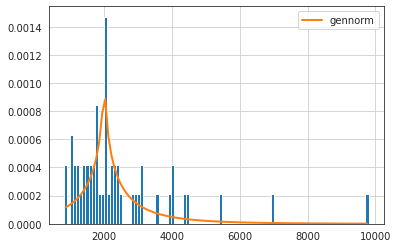

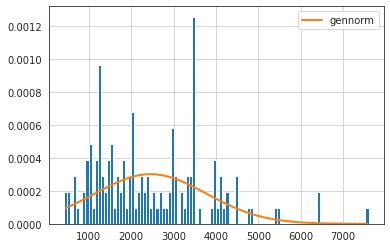

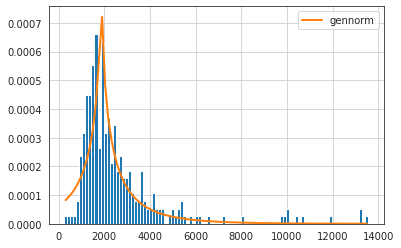

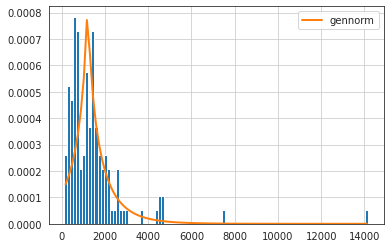

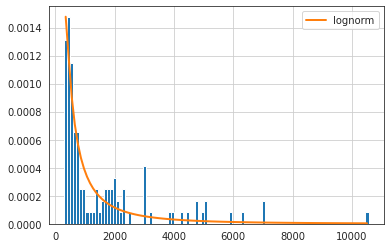

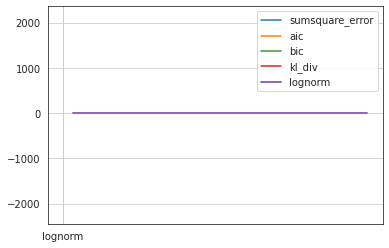

In [6]:
Fits_CAFOs_Summary = dict()
for state in CAFOs_Merged:
    fitting_values = CAFOs_Merged[state].dropna().values
    
    if CAFOs_Merged.describe().loc['count'][state] <100:

        fit_variable = Fitter(fitting_values,
                       distributions=['gennorm']
                                             )
        
    elif state == 'Indiana':
        fit_variable = Fitter(fitting_values,
                       distributions=['lognorm']
                                             )
        
    else:
        fit_variable = Fitter(fitting_values,
                       distributions=['gennorm']
                                             )
    
    
    fit_variable.fit()
    print(state)
    fit_variable.summary()
    Fits_CAFOs_Summary[state] = fit_variable.summary()
    fit_variable.summary().plot()
    fit_variable.plot_pdf()

In [7]:
# a = fit_variable.summary(plotsavename="a")  # s is an instance of Series
# fig = ax[0][0].get_figure()
fit_variable = Fitter(CAFOs_Merged['Ohio'].dropna().values,
                       distributions=['gennorm']
                                             )
fit_variable.fit()
fit_variable.fitted_param["gennorm"]

(0.563217072107863, 2000.0000000181408, 250.54296180173372)

In [ ]:
dist = getattr(stats, 'gennorm')
dist.fit(CAFOs_Merged['Ohio'].dropna().values)

stat='count',

In [8]:
beta1, loc1, scale1 = stats.gennorm.fit(CAFOs_Merged['Ohio'].dropna().values)

In [9]:
beta1

0.563217072107863

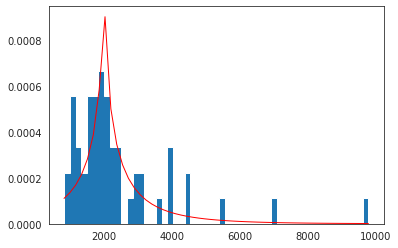

In [16]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(CAFOs_Merged['Ohio'].dropna().values.min(),CAFOs_Merged['Ohio'].dropna().values.max(),CAFOs_Merged['Ohio'].dropna().count())
# ax = plt.plot(stats.gennorm.pdf(x, beta1, loc=loc1, scale=scale1))
ax.plot(x, stats.gennorm.pdf(x, beta1, loc1, scale1),
       'r-', lw=1, alpha=1, label='gennorm pdf')
# ax.plot(x, stats.gennorm.pdf(np.linspace(stats.gennorm.ppf(0.01, 1.3),
#                 stats.gennorm.ppf(0.99, 1.3), 100), 1.3),
       # 'r-', lw=5, alpha=0.6, label='gennorm pdf')
ax = plt.hist(CAFOs_Merged['Ohio'].dropna().values, bins=CAFOs_Merged['Ohio'].dropna().count(), density=True, histtype='stepfilled', alpha=1) #NumberOfBins(CAFOs_Merged['Ohio'].dropna())

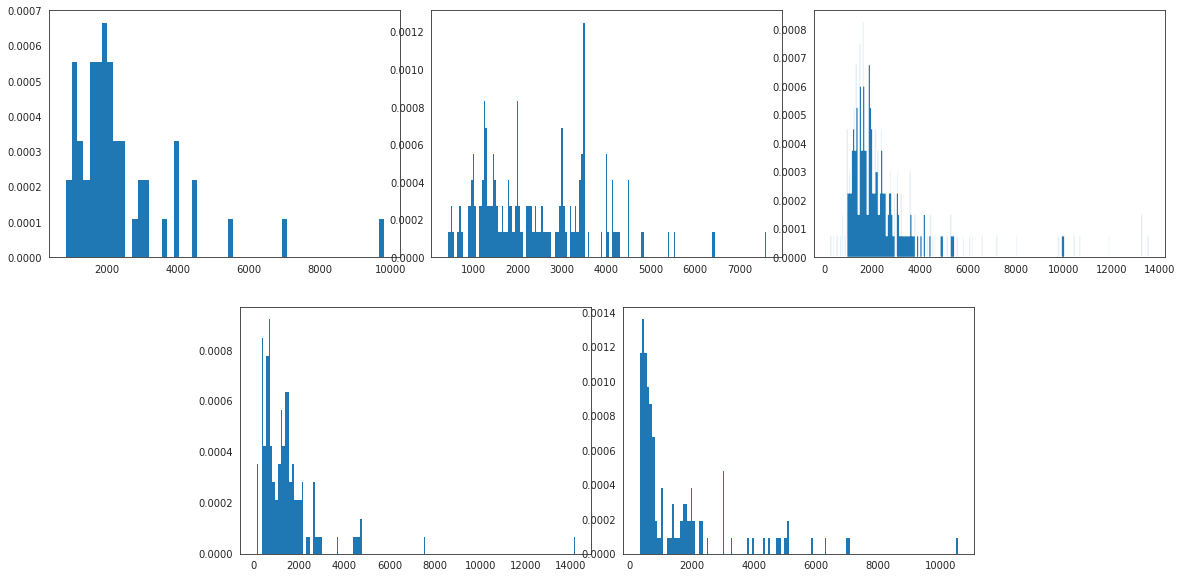

In [31]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 6)

count = 0
for state in CAFOs_Merged.columns:
    alpha1, beta1, loc1, scale1 = stats.truncnorm.fit(CAFOs_Merged[state].dropna().values)
    x = np.linspace(CAFOs_Merged[state].dropna().values.min(),CAFOs_Merged[state].dropna().values.max(),CAFOs_Merged[state].dropna().count())
    if count < 3: #This is for centering the last row of plots
        ax = plt.subplot(gs[0, 2 * count:2 * count + 2])
    else:
        ax = plt.subplot(gs[1, 2 * count - 5:2 * count + 2 - 5])
              
    ax.plot(x, stats.truncnorm.pdf(x, alpha1, beta1, loc1, scale1),'r-', lw=1, alpha=1, label='gennorm pdf')
    ax = plt.hist(CAFOs_Merged[state].dropna().values, bins=CAFOs_Merged[state].dropna().count(), density=True, histtype='stepfilled', alpha=1) #NumberOfBins(CAFOs_Merged['Ohio'].dropna())
    count = count+1

In [71]:
beta1, loc1, scale1 = stats..fit(CAFOs_Merged['Wisconsin'].dropna().values)

# Since the size of CAFOs are limited between 300 and 10,000, we used a truncated normal distribution

(array([0.00010435, 0.        , 0.        , 0.        , 0.00010435,
        0.        , 0.        , 0.00010435, 0.        , 0.        ,
        0.00010435, 0.00010435, 0.        , 0.00010435, 0.        ,
        0.00010435, 0.00041741, 0.00041741, 0.        , 0.00052176,
        0.0002087 , 0.00052176, 0.00041741, 0.0002087 , 0.00073046,
        0.00031305, 0.00041741, 0.00073046, 0.00062611, 0.00010435,
        0.00052176, 0.00073046, 0.00073046, 0.00041741, 0.00083481,
        0.00052176, 0.00073046, 0.00031305, 0.00052176, 0.00031305,
        0.0002087 , 0.00031305, 0.00083481, 0.00062611, 0.00052176,
        0.00052176, 0.00052176, 0.0002087 , 0.00010435, 0.00041741,
        0.00052176, 0.00031305, 0.00031305, 0.00031305, 0.00010435,
        0.0002087 , 0.0002087 , 0.00052176, 0.00052176, 0.00010435,
        0.0002087 , 0.00031305, 0.00031305, 0.00010435, 0.        ,
        0.00031305, 0.00010435, 0.00031305, 0.00031305, 0.0002087 ,
        0.00010435, 0.0002087 , 0.        , 0.00

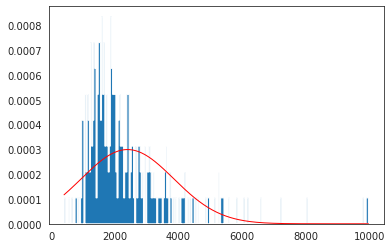

In [92]:
x = np.linspace(CAFOs_Merged['Wisconsin'].dropna().values.min(),CAFOs_Merged['Wisconsin'].dropna().values.max(),CAFOs_Merged['Wisconsin'].dropna().count())
plt.plot(x, stats.truncnorm.pdf(x,
                                (CAFOs_Merged['Wisconsin'].dropna().values.min()-2393.431159)/1457.032638,
                                (CAFOs_Merged['Wisconsin'].dropna().values.max()-2393.431159)/1457.032638,
                                loc =2393.431159,
                                scale =1457.032638),'r-', lw=1, alpha=1, label='gennorm pdf')
# plt.plot(x, stats.gennorm.pdf(x,
#                                 beta1, loc1, scale1	),'r-', lw=1, alpha=1, label='gennorm pdf')
plt.hist(CAFOs_Merged['Wisconsin'].dropna().values, bins=CAFOs_Merged['Wisconsin'].dropna().count(), density=True, histtype='stepfilled', alpha=1)

In [93]:
func = lambda x: stats.truncnorm.pdf(x,
                                (CAFOs_Merged['Wisconsin'].dropna().values.min()-2393.431159)/1457.032638,
                                (CAFOs_Merged['Wisconsin'].dropna().values.max()-2393.431159)/1457.032638,
                                loc =2393.431159,
                                scale =1457.032638)

integrate.quad(func, CAFOs_Merged['Wisconsin'].dropna().values.min(), CAFOs_Merged['Wisconsin'].dropna().values.max())

(1.0000000000000004, 1.888688728914604e-14)

In [73]:
func = lambda x: stats.gennorm.pdf(x,
                                beta1, loc1, scale1	)

integrate.quad(func, CAFOs_Merged['Wisconsin'].dropna().values.min(), CAFOs_Merged['Wisconsin'].dropna().values.max())

(0.8890356521974687, 7.723436329311568e-09)

In [91]:
CAFOs_Merged['Wisconsin'].dropna().values.min()

396.0